In [2]:
"""This file contains the pipeline for training and evaluating the GCN on the data."""
import os
import sys
import random
import numpy as np
import pandas as pd
import datetime
from typeguard import typechecked
import pickle

import networkx
import torch
from torch_geometric.data import Data
from torch_geometric.utils.convert import from_networkx

from sklearn.model_selection import train_test_split

from tqdm import tqdm
sys.path.append("/home/jovyan/20230406_ArticleClassifier/ArticleClassifier")

import src.general.global_variables as gv

sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname('data_loader.py'), os.path.pardir)))
from src.data.data_loader import DataLoader
from src.data.data_processing import standardise_embeddings, convert_networkx_to_torch, get_mask
from src.visualization.visualize import tsne, plot_metrics_during_training

from src.general.utils import cc_path
from src.models.evaluation import Metrics


import matplotlib.pyplot as plt

from src.models.graph_network_models.single_stream_gat import GAT
from src.models.graph_network_models.single_stream_gcn import GCN
from src.models.graph_network_models.single_stream_graphtransformer import GraphTransformer
from src.models.graph_network_models.single_stream_sage import SAGE


from src.models.graph_network_models.dual_stream_gcn import dualGCN
from src.models.graph_network_models.dual_stream_gat import dualGAT

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


def train(model: torch.nn.Module, data: list[Data], optimizer, criterion):
    """
    Perform one training iteration of the model.

    Args:
        model ():
        data ():
        optimizer ():
        criterion ():

    Returns:

    """
    data_inputs = [d for data_object in data for d in (data_object.x, data_object.edge_index)]

    model.train()
    optimizer.zero_grad()
    out = model(*data_inputs)
    loss = criterion(out[data[0].train_mask], data[0].y[data[0].train_mask])
    loss.backward()
    optimizer.step()
    return loss


def evaluate_metrics(model: torch.nn.Module, data: list[Data], dataset: str = 'test', show: bool = False) -> dict:
    """
    Calculate the different metrics for the specified dataset.

    Args:
        model (torch.nn.Module): The initiated model
        data (Data): The Torch dataset
        dataset (str): The dataset to specify the metrics for

    Returns:
        Dictionary with the metrics
    """
    if dataset == 'test':
        mask = data[0].test_mask
    elif dataset == 'train':
        mask = data[0].train_mask
    else:
        assert False, f'Dataset {dataset} not recognised. Should be "train" or "test".'
    model.eval()

    data_inputs = [d for data_object in data for d in (data_object.x, data_object.edge_index)]

    out = model(*data_inputs)
    pred = out

    metric_calculator = Metrics(pred[mask].detach().numpy(), data[0].y[mask].detach().numpy(),
                                threshold=0.5)
    metrics = metric_calculator.retrieve_all_metrics()
    
    if show:
        print('The metrics: ', metrics)

    return metrics


def initiate_model(gnn_type, model_parameters, num_features, num_labels):
    if gnn_type == 'GCN':
        model = GCN(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                    num_labels=num_labels)
    elif gnn_type == 'GAT':
        model = GAT(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                    num_labels=num_labels, num_conv_layers=model_parameters['num_conv_layers'],
                    heads=model_parameters['heads'], embedding_size=model_parameters['embedding_size'])
    elif gnn_type == 'GIN':
        model = GIN(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                    num_labels=num_labels, num_conv_layers=model_parameters['num_conv_layers'],
                    embedding_size=model_parameters['embedding_size'])
    elif gnn_type == 'dualGCN':
        model = dualGCN(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                        num_labels=num_labels)
    elif gnn_type == 'dualGAT':
        model = dualGAT(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                        num_labels=num_labels,
                        heads=model_parameters['heads'])
    elif gnn_type == 'SAGE':
        model = SAGE(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
            num_labels=num_labels)
    elif gnn_type == 'GraphTransformer':
        model = GraphTransformer(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                    num_labels=num_labels,
                    heads=model_parameters['heads'])    
    
    else:
        assert False, f'Model type: {gnn_type} not recognised, must be in: ["GCN", "GAT", "dualGCN", "dualGAT", "SAGE"]'

    return model

## Set model parameters

In [3]:
# current models to choose from: ["GCN", "GAT", 'SAGE', 'GraphTransformer', "dualGCN", "dualGAT"]
# current embedding_types to choose from: ["general", "label_specific", 'scbert']

now = datetime.datetime.now()
run_id = datetime.datetime.now().strftime('%Y%m%d%H%M%S')

gnn_type = 'GAT'
subsample_size = 56337
data_type_to_use = ['author']
embedding_type = 'scibert'

all_model_parameters = {
    "GAT": {
        'embedding_size': 128,
        'hidden_channels': 64,
        'heads': 8,
        'num_conv_layers': 1
    },
    "GraphTransformer": {
        'hidden_channels': 32,
        'heads': 8
    },
    "GCN": {
        'hidden_channels': 64
    },
    "SAGE": {
        'hidden_channels': 32,
        'heads': 4
    },
    "dualGAT": {
        'hidden_channels': 32,
        'heads': 4
    },
    "dualGCN": {
        'hidden_channels': 32
    },
    "GIN": {
        'embedding_size': 128,
        'hidden_channels': 64,
        'num_conv_layers': 2
    }
}

## Load and process the data

In [4]:
# load all the data
print('Start loading data...')
loc_dict = {
    'processed_csv': cc_path('data/processed/canary/articles_cleaned.csv'),
    'abstract_embeddings': cc_path('data/processed/canary/embeddings_fasttext_20230410.csv'),
    'scibert_embeddings': cc_path('data/processed/canary/embeddings_scibert_finetuned_20230425.csv'),
    'keyword_network': cc_path('data/processed/canary/keyword_network_weighted.pickle'),
    'xml_embeddings': cc_path('data/processed/canary/embeddings_xml.ftr'),
    'author_network': cc_path('data/processed/canary/author_network.pickle'), 
    'label_network': cc_path('data/processed/canary/label_network_weighted.pickle')
}
data_loader = DataLoader(loc_dict)
processed_df = data_loader.load_processed_csv()
author_networkx = data_loader.load_author_network()
keyword_network = data_loader.load_keyword_network()
label_network = data_loader.load_label_network()

label_data = from_networkx(label_network)

all_data = {
    'author': author_networkx,
    'keyword': keyword_network,
    'label': label_data
}

Start loading data...


In [5]:
# process all data
if embedding_type == 'general':
    embedding_df = data_loader.load_embeddings_csv()
    embedding_df = standardise_embeddings(embedding_df)
elif embedding_type == 'scibert':
    embedding_df = data_loader.load_scibert_embeddings_csv()
    embedding_df = standardise_embeddings(embedding_df)
elif embedding_type == 'label_specific':
    embedding_df = data_loader.load_xml_embeddings()

print('Start processing data...')
print('Standardising embeddings...') 


# process the labels we want to select now

label_columns = processed_df.loc[:, ~processed_df.columns.isin(
    ['file_name', 'title', 'keywords', 'abstract', 'abstract_2', 'authors', 'organization', 'chemicals',
     'num_refs', 'date-delivered', 'labels_m', 'labels_a'])]

# label_columns = processed_df.loc[:, ['pui', 'human', 'mouse', 'rat', 'nonhuman',
#                                      'controlled study', 'animal experiment']]
label_columns[label_columns.columns.difference(['pui'])] = label_columns[
    label_columns.columns.difference(['pui'])].astype(str)
features = ['file_name', 'pui', 'title', 'keywords', 'abstract', 'abstract_2', 'authors', 'organization',
            'chemicals',
            'num_refs', 'date-delivered', 'labels_m', 'labels_a']

# drop all nodes that do not have an embedding
# nodes_to_remove = []
# for network in [author_networkx, keyword_network]:
#     nodes_to_remove += [node for node in list(network.nodes) if not node in embedding_df.pui.to_list()]
#
# for node in nodes_to_remove:
#     for network in [author_networkx, keyword_network]:
#         network.remove_node(node)

Start processing data...
Standardising embeddings...


/tmp/ipykernel_303/511798419.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_columns[label_columns.columns.difference(['pui'])] = label_columns[


In [6]:
to_remove = [(a,b) for a, b, attrs in keyword_network.edges(data=True) if attrs["weight"] < 1/200]
keyword_network.remove_edges_from(to_remove)

In [7]:
len(list(set(embedding_df.pui.to_list())))

117310

In [8]:
print(len(list(set(author_networkx.nodes) & set(keyword_network.nodes) & set(embedding_df.pui.astype(str).to_list()))))
print(len(list(set(embedding_df.pui.astype(str).to_list()) & set(keyword_network.nodes))))

print(len(author_networkx.nodes))
print(len(keyword_network.nodes))
print(len(author_networkx.edges))
print(len(keyword_network.edges))

56337
96163
71727
97196
163133
542224


In [9]:
# get down-sampled networks
print('Sampling the graphs...')
available_nodes = list(set(author_networkx.nodes) & set(keyword_network.nodes) & set(embedding_df.pui.to_list()))
print('keyword', len(set(keyword_network.nodes)))
print('author', len(set(author_networkx.nodes)))
print('embedding', len(set(embedding_df.pui.to_list())))

sampled_nodes = random.sample(available_nodes, subsample_size)
sampled_author = author_networkx.subgraph(sampled_nodes).copy()
sampled_keyword = keyword_network.subgraph(sampled_nodes).copy()

# nodes can only have incremental integers as labels, so we create a mapping to remember which pui is which idx
node_label_mapping = dict(zip(sampled_author.nodes, range(len(sampled_author))))

Sampling the graphs...
keyword 97196
author 71727
embedding 117310


In [10]:
inverse_node_label_mapping = inv_map = {v: k for k, v in node_label_mapping.items()}


In [11]:
def write_indices_to_txt(indices, data_set):
    # open file in write mode
    with open(cc_path(f'data/{data_set}_indices.txt'), 'w') as fp:
        for item in indices:
            # write each item on a new line
            fp.write("%s\n" % item)
        print('Done')

In [12]:
# train_indices, test_indices = train_test_split(range(len(sampled_author)), test_size=0.2, random_state=0)
# train_indices, val_indices = train_test_split(train_indices, test_size=0.2, random_state=0)

# write_indices_to_txt(list(map(inverse_node_label_mapping.get, train_indices)), data_set='train')
# write_indices_to_txt(list(map(inverse_node_label_mapping.get, test_indices)), data_set='test')
# write_indices_to_txt(list(map(inverse_node_label_mapping.get, val_indices)), data_set='val')

# import json
# with open(cc_path("data/inverse_pui_idx_mapping.json"), "w") as outfile:
#     json.dump(inverse_node_label_mapping, outfile)
    
# with open(cc_path("data/pui_idx_mapping.json"), "w") as outfile:
#     json.dump(node_label_mapping, outfile)

In [13]:
import json

with open(cc_path("data/pui_idx_mapping.json"), "r") as outfile:
    node_label_mapping = json.load(outfile)
    
with open(cc_path(f'data/train_indices.txt')) as f:
    train_puis = f.read().splitlines()
    train_indices = list(map(node_label_mapping.get, train_puis))
with open(cc_path(f'data/val_indices.txt')) as f:
    val_puis = f.read().splitlines()
    val_indices = list(map(node_label_mapping.get, val_puis))
with open(cc_path(f'data/test_indices.txt')) as f:
    test_puis = f.read().splitlines()
    test_indices = list(map(node_label_mapping.get, test_puis))

In [14]:
# create train and test split
print('Creating torch datasets...')

train_mask = get_mask(train_indices, len(sampled_author))
val_mask = get_mask(val_indices, len(sampled_author))
test_mask = get_mask(test_indices, len(sampled_author))
author_data = convert_networkx_to_torch(sampled_author, embedding_df, label_columns, train_mask, val_mask,
                                 node_label_mapping, embedding_type)
keyword_data = convert_networkx_to_torch(sampled_keyword, embedding_df, label_columns, train_mask, val_mask,
                                  node_label_mapping, embedding_type)

Creating torch datasets...


In [15]:
author_data.edge_index

tensor([[38119, 38119, 38119,  ..., 56334, 56335, 56336],
        [ 1395,  7824, 25485,  ..., 56334, 56335, 56336]])

In [16]:
from torch_geometric.utils import contains_self_loops,is_undirected
is_undirected(author_data.edge_index)

False

## Easy testing of model classes

In [17]:
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv

class ResidualConnection(torch.nn.Module):
    def __init__(self, alpha=0.5):
        super(ResidualConnection, self).__init__()
        self.alpha = alpha

    def forward(self, Xs: list):
        assert len(Xs) >= 1
        return Xs[-1] if len(Xs) == 1 else (1 - self.alpha) * Xs[-1] + self.alpha * Xs[-2]

class InitialConnection(torch.nn.Module):
    def __init__(self, alpha=0.5):
        super(InitialConnection, self).__init__()
        self.alpha = alpha

    def forward(self, Xs: list):
        assert len(Xs) >= 1
        return Xs[-1] if len(Xs) == 1 else (1 - self.alpha) * Xs[-1] + self.alpha * Xs[0]
    
class DenseConnection(torch.nn.Module):
    def __init__(self, in_dim, out_dim, aggregation='concat'):
        super(DenseConnection, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.aggregation = aggregation
        if aggregation == 'concat':
            self.layer_transform = torch.nn.Linear(in_dim, out_dim, bias=True)
        elif aggregation == 'attention':
            self.layer_att = torch.nn.Linear(512, 1, bias=True)

    def forward(self, Xs: list):
        assert len(Xs) >= 1
        if self.aggregation == 'concat':
            X = torch.cat(Xs, dim=-1)
            X = self.layer_transform(X)
            return X
        elif self.aggregation == 'maxpool':
            X = torch.stack(Xs, dim=-1)
            X, _ = torch.max(X, dim=-1, keepdim=False)
            return X
        # implement with the code from https://github.com/mengliu1998/DeeperGNN/blob/master/DeeperGNN/dagnn.py
        elif self.aggregation == 'attention':
            # pps n x k+1 x c
            pps = torch.stack(Xs, dim=1)
            retain_score = self.layer_att(pps).squeeze()
            retain_score = torch.sigmoid(retain_score).unsqueeze(1)
            X = torch.matmul(retain_score, pps).squeeze()
            return X
        else:
            raise Exception("Unknown aggregation")

class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, num_heads):
        super(GNN, self).__init__()
        self.num_layers = num_layers
        
        self.convs = torch.nn.ModuleList()
        self.convs.append(GATv2Conv(in_channels, hidden_channels, heads=num_heads))
        for i in range(2, num_layers):
            self.convs.append(GATv2Conv(hidden_channels*num_heads, hidden_channels, heads=num_heads))
        self.conv_last = GATv2Conv(hidden_channels*num_heads, out_channels, heads=num_heads)
        
        self.lin1 = torch.nn.Linear(hidden_channels*num_heads, out_channels)
        self.lin2 = torch.nn.Linear(out_channels, out_channels)
        self.sigmoid = torch.nn.Sigmoid()
        # self.skip_layers = DenseConnection(hidden_channels * num_heads * (num_layers-1), out_channels, aggregation='attention')
        self.skip_layers = InitialConnection(alpha=0.5)

        
    def forward(self, x, edge_index):
        xs = []
        x1 = F.dropout(torch.relu(self.convs[0](x, edge_index)), p=0.6, training=self.training)
        xs.append(x1)
        x_new = x1

        for i in range(self.num_layers - 2):
            x_new = F.dropout(torch.relu(self.convs[i+1](x_new, edge_index)), p=0.1, training=self.training)
            xs.append(x_new)
        x_last = self.skip_layers(xs)
        
        x = F.relu(self.lin1(x_last))
        x = self.lin2(x)
        x = self.sigmoid(x)

        return x

    
model = GNN(author_data.x.shape[1], 64, 52, 4, 4)

In [18]:
"""This file defines the GAT single stream model."""

from torch_geometric.nn import GINConv
import torch
import torch.nn.functional as F


class GIN(torch.nn.Module):
    def __init__(self, hidden_channels, embedding_size, num_features, num_labels, num_conv_layers, heads):
        super().__init__()
        torch.manual_seed(1234567)
        
        self.num_layers = num_conv_layers
        
        # set up all the convolutional layers
        self.convs = torch.nn.ModuleList()
        
        if self.num_layers > 1:
            self.convs.append(GINConv(num_features, hidden_channels, heads))
            for i in range(2, self.num_layers):
                self.convs.append(GINConv(heads * hidden_channels, hidden_channels, heads))
            self.convs.append(GINConv(hidden_channels*heads, embedding_size, heads=heads))
        else:
            self.convs.append(GINConv(num_features, embedding_size, heads))

        # self.linear_final_1 = torch.nn.Linear(embedding_size*heads, num_labels*10)
        # self.linear_final_2 = torch.nn.Linear(num_labels*10, num_labels*5)
        # self.linear_final_3 = torch.nn.Linear(num_labels*5, num_labels)

        self.linear_final_end = torch.nn.Linear(embedding_size*heads, num_labels)

        # self.self_attention_layer = torch.nn.MultiheadAttention(num_labels, num_heads=1, dropout=0.1)


    def forward(self, x, edge_index, return_embeddings=False):
        # propagate input through convolutional layers
        for i in range(self.num_layers):
            x = F.dropout(F.elu(self.convs[i](x, edge_index)), p=0.1, training=self.training)
        
        # return embeddings instead of class probabilities
        if return_embeddings:
            return x

        # calculate label probabilies with an MLP classification head
        # x = F.elu(x)
        # x = self.linear_final_1(x)
        # x = F.elu(x)
        # x = self.linear_final_2(x)
        # x = F.elu(x)
        # x = self.linear_final_3(x)
        
        x =  self.linear_final_end(x)
        
        
        # x, _ = self.self_attention_layer(x, x, x)

        return torch.sigmoid(x)
    

# Modelling

## Initiate Model

In [19]:
# initiate the model
model = initiate_model(
    gnn_type,
    all_model_parameters[gnn_type],
    num_features=author_data.x.shape[1],
    num_labels=len(label_columns.columns) - 1
)

In [20]:
print(model)

GAT(
  (convs): ModuleList(
    (0): GATv2Conv(768, 128, heads=8)
  )
  (linear_final_end): Linear(in_features=1024, out_features=52, bias=True)
)


## pretrain Model

In [21]:
from src.models.pretraining import NegativeEdge, BatchAE, train_pretrain, DataLoaderAE


transform =  NegativeEdge()
transformed_author_data = transform(author_data)

#set up optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)
criterion_pretrain = torch.nn.BCEWithLogitsLoss()


In [22]:
author_data.edge_index

tensor([[38119, 38119, 38119,  ..., 56334, 56335, 56336],
        [ 1395,  7824, 25485,  ..., 56334, 56335, 56336]])

Train acc: 0.7406868934631348, Train loss: 34.388423919677734: 100%|██████████| 1/1 [00:06<00:00,  6.73s/it]


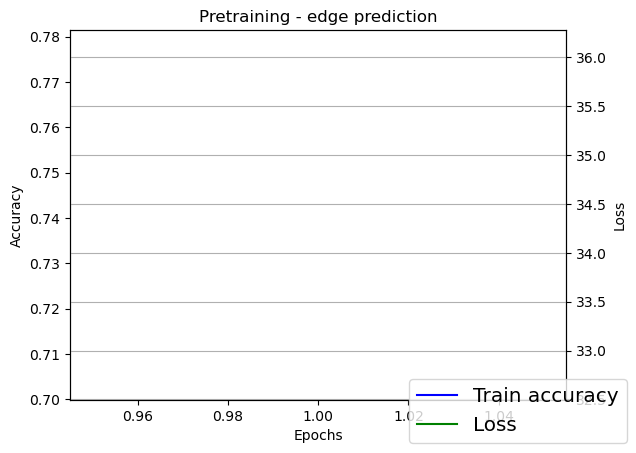

In [23]:

#optimizer = optim.Adam(model.graph_pred_linear.parameters(), lr=args.lr, weight_decay=args.decay)    


train_acc = 0
pretrain_epochs = 2
train_losses = []
train_accs = []
for epoch in (pbar := tqdm(range(1, pretrain_epochs))):
    model, train_acc, train_loss = train_pretrain(model, device, None, optimizer, BatchAE([transformed_author_data]).batch[0], criterion_pretrain)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    pbar.set_description(f'Train acc: {train_acc}, Train loss: {train_loss}')

fig, ax1 = plt.subplots()
ax1.plot(np.arange(1, len(train_losses) + 1),train_accs , label='Train accuracy', c='blue')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

ax2 = ax1.twinx()
ax2.set_ylabel('Loss')
ax2.plot(np.arange(1, len(train_accs) + 1), train_losses, label='Loss', c='green')

plt.title(f'Pretraining - edge prediction')
fig.legend(loc='lower right', fontsize='x-large')
plt.grid()
plt.show()

torch.save(model, cc_path(f'models/pretrained_graphs/{run_id}_pretained.pt'))

## run test prediction

In [24]:
model.eval()

all_torch_data = {
    'author': author_data,
    'keyword': keyword_data,
    'label': label_data
}

# get the output of an untrained model
data = [all_torch_data[datatype] for datatype in data_type_to_use]
print('This is the data object: ', data)
data_inputs = [d for data_object in data for d in (data_object.x, data_object.edge_index)]

# model.set_label_embeddings(*data_inputs[3:])

out = model(*data_inputs)
print('The predictions of the test set before training: ', out[author_data.test_mask].detach().numpy())
# visualize(out, color=data.y.argmax(dim=1))

This is the data object:  [Data(x=[56337, 768], edge_index=[2, 223556], y=[56337, 52], train_mask=[56337], test_mask=[56337], edge_weight=[121812], batch_size=64, negative_edge_index=[2, 111778])]
The predictions of the test set before training:  [[0.42747855 0.5283665  0.5778995  ... 0.52180696 0.41035387 0.6234478 ]
 [0.522163   0.42949536 0.6110203  ... 0.5817144  0.551409   0.456554  ]
 [0.4604033  0.52027255 0.3632926  ... 0.5100789  0.57267755 0.6162036 ]
 ...
 [0.45795456 0.36404198 0.45840248 ... 0.437102   0.49664146 0.41226134]
 [0.4646687  0.3090421  0.4408801  ... 0.4779394  0.5004893  0.39747941]
 [0.43179154 0.3854393  0.5672341  ... 0.5305479  0.48974535 0.5314075 ]]


### Set model training parameters

In [25]:
# set training parameters
print('Start training procedure...')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# label_occs = label_columns[label_columns.columns.difference(['pui'])].sum().to_list()
# weight = torch.tensor(label_occs) / sum(label_occs)

criterion = torch.nn.BCELoss()

Start training procedure...


### Train model

In [26]:
# train model
all_metrics = evaluate_metrics(model, data, dataset='train').keys()
train_metrics_all = {key: [] for key in all_metrics}
test_metrics_all = {key: [] for key in all_metrics}
loss_all = []

graph_num_epochs = 2
for epoch in (pbar := tqdm(range(1, graph_num_epochs))):
    loss = train(model, data, optimizer, criterion)

    train_metrics = evaluate_metrics(model, data, dataset='train', show=False)
    test_metrics = evaluate_metrics(model, data, dataset='test', show=False)

    for metric in train_metrics.keys():
        train_metrics_all[metric].append(train_metrics[metric])
        test_metrics_all[metric].append(test_metrics[metric])

    loss_all.append(loss.item())
    pbar.set_description(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Train - F1 {train_metrics['Macro F1 score']}, Val - F1 {test_metrics['Macro F1 score']}")

torch.save(model, cc_path(f'models/supervised_graphs/{run_id}_supervised.pt'))
    
print(test_metrics)

Epoch: 001, Loss: 0.7053, Train - F1 0.23172553280894237, Val - F1 0.22930751187800794: 100%|██████████| 1/1 [00:08<00:00,  8.52s/it]

{'Precision': [0.15994130594277328, 0.7326124354878348, 0.4379263301500682, 0.1377049180327869, 0.3049103204939724, 0.24559245592455925, 0.21995094031071136, 0.024651972157772623, 0.14779874213836477, 0.20541137493097736, 0.3730387447966699, 0.04663737749239608, 0.26191237607930923, 0.001953125, 0.7200181364769893, 0.12416009348524686, 0.005166289958023894, 0.02055076037813399, 0.02570093457943925, 0.019321597252039503, 0.7983028720626631, 0.011705685618729096, 0.9511354420113545, 0.237387805632931, 0.029134917077543704, 0.21854071201973915, 0.048337200309358085, 0.027158492095662748, 0.6017102876392848, 0.8121693121693122, 0.007715387912558937, 0.2141185647425897, 0.2146031746031746, 0.05414551607445008, 0.03389830508474576, 0.6045845272206304, 0.010660980810234541, 0.057980456026058634, 0.002177858439201452, 0.002416918429003021, 0.00832072617246596, 0.0003972983710766786, 0.026189436927106065, 0.02096924510717614, 0.08025682182985554, 0.07132459970887918, 0.28084223013048637, 0.0152

### Model Evaluation

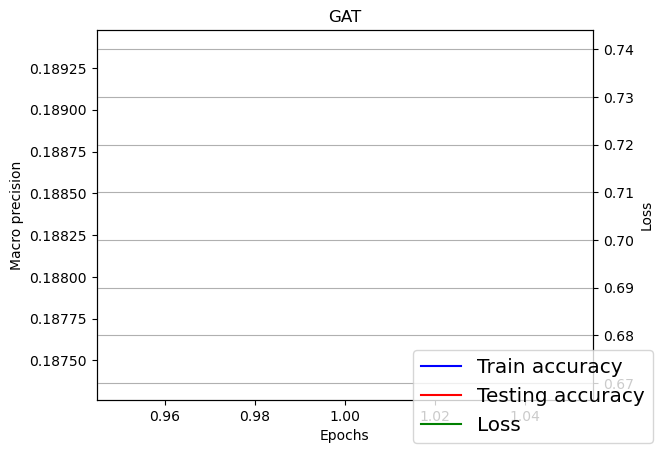

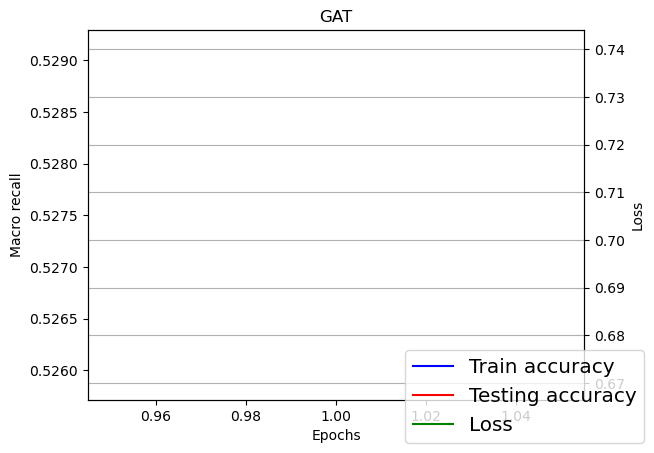

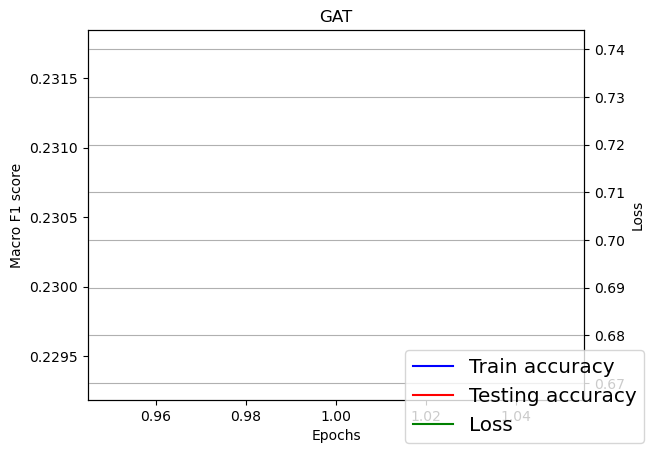

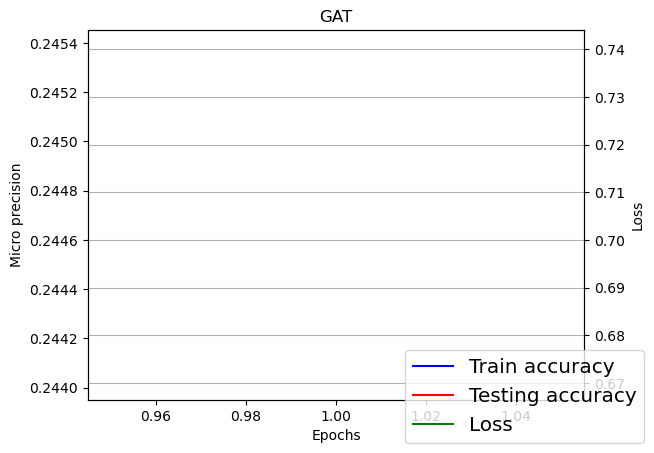

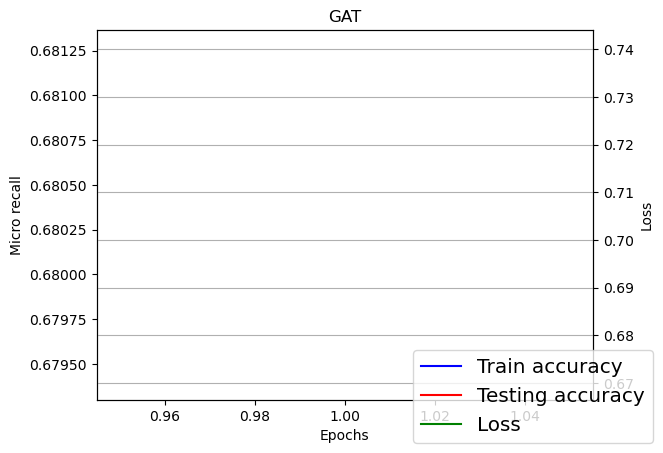

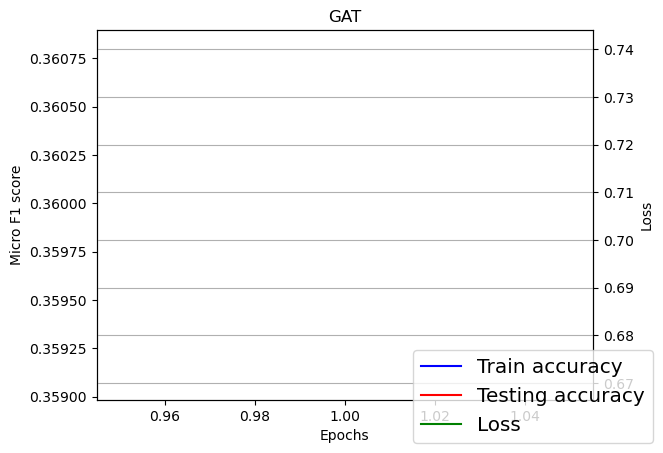

The predictions of the test set before training:  [[0.3773216  0.22933067 0.3987614  ... 0.49456513 0.34363317 0.46810463]
 [0.43406075 0.65333056 0.7266107  ... 0.5345116  0.50903857 0.45523292]
 [0.42728728 0.6440706  0.4110821  ... 0.48471412 0.5214872  0.6024029 ]
 ...
 [0.4104565  0.20574903 0.35704997 ... 0.45735595 0.48216233 0.34480765]
 [0.43404913 0.1765661  0.39023307 ... 0.50217974 0.5224266  0.3725448 ]
 [0.44831496 0.2152307  0.44070694 ... 0.530887   0.4885137  0.48896882]]
Evaluating model performance...
The metrics:  {'Precision': [0.1808972503617945, 0.7361446529196854, 0.43635739421508885, 0.13552814312556163, 0.30573523070288916, 0.25148375414948193, 0.23078485812961333, 0.02261783160659565, 0.15295920012901146, 0.21415319374503047, 0.37936230964467005, 0.04350051177072672, 0.26806822689408966, 0.004130246854288733, 0.7356633864947404, 0.11347105033459412, 0.007220216606498195, 0.019806065607592325, 0.027030109489051095, 0.023512861736334406, 0.8017988552739166, 0.0

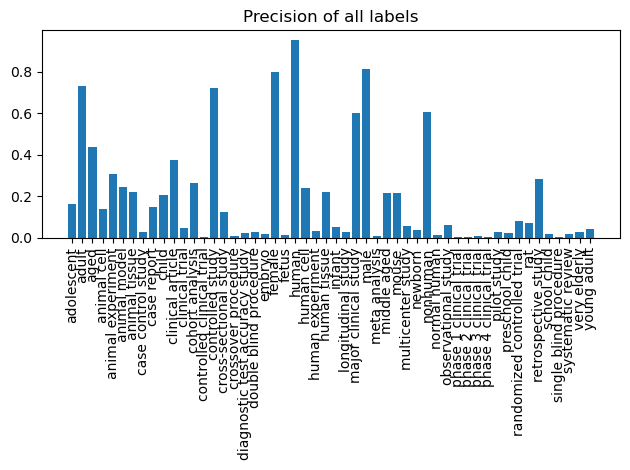

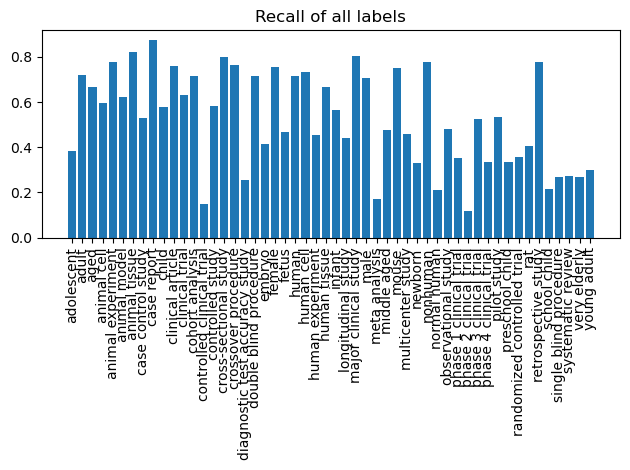

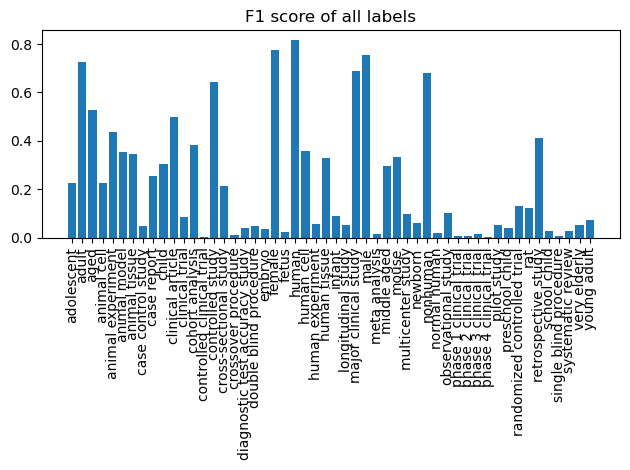

In [27]:
import matplotlib.pyplot as plt
today = datetime.date.today()
now = datetime.datetime.now()
time = now.strftime("%H-%M-%S")

image_path = cc_path(f'reports/figures/classification_results/{today}/')
if not os.path.exists(image_path):
    os.mkdir(image_path)
os.mkdir(image_path + f'{time}/')
for metric in all_metrics:
    if 'Micro' in metric or 'Macro' in metric:
        plot_metrics_during_training(train_metrics_all[metric], test_metrics_all[metric], loss_all, model_name=gnn_type, metric_name=metric, today=today, time=time)


# get output from trained model
model.eval()
out = model(*data_inputs)
print('The predictions of the test set before training: ', out[author_data.test_mask].detach().numpy())

# get the test accuracy
print('Evaluating model performance...')
train_end_metrics = evaluate_metrics(model, data, dataset='train', show=True)
test_end_metrics = evaluate_metrics(model, data, dataset='test', show=True)


for metric in all_metrics:
    if not 'Micro' in metric and not 'Macro' in metric:
        plt.figure()
        plt.title(f'{metric} of all labels')
        plt.bar(range(len(label_columns.columns.difference(['pui']))), test_end_metrics[metric], tick_label=label_columns.columns.difference(['pui']))
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.savefig(cc_path(f'reports/figures/classification_results/{today}/{time}/{gnn_type}_{metric}_label.png'))
        plt.show()

# print(f'Test Accuracy: {test_acc:.4f}')

# visualize(out, color=data.y.argmax(dim=1))

### train classification head on graph node embeddings

In [28]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
import lightgbm as gbm

In [29]:
graph_created_embeddings = model.forward(data_inputs[0], data_inputs[1], return_embeddings=True)
X_train_graph_embeddings = graph_created_embeddings[author_data.train_mask].detach().numpy()
X_test_graph_embeddings = graph_created_embeddings[author_data.test_mask].detach().numpy()
y_train_graph_embeddings = author_data.y[author_data.train_mask].detach().numpy()
y_test_graph_embeddings = author_data.y[author_data.test_mask].detach().numpy()

In [30]:
# create a classifier for each class
lgbm_params = {
    'n_estimators': 500,
    'is_unbalance': True,
    'n_jobs': -1
}

num_labels = 52
clfs = []
for i in range(num_labels):
    clfs.append(gbm.LGBMClassifier(**lgbm_params))


In [31]:
for i in tqdm(range(num_labels)):
     clfs[i] = clfs[i].fit(X_train_graph_embeddings, y_train_graph_embeddings[:, i], callbacks=[gbm.log_evaluation(period=100), gbm.early_stopping(10)], eval_set=(X_test_graph_embeddings, y_test_graph_embeddings[:, i]))
    
# Save the list of trained models to a file
with open(cc_path(f'models/classification_heads/{run_id}_classification_head.pkl'), 'wb') as f:
    pickle.dump(clfs, f)


  0%|          | 0/52 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds


  2%|▏         | 1/52 [00:05<04:58,  5.85s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.21403
Training until validation scores don't improve for 10 rounds


  4%|▍         | 2/52 [00:19<08:28, 10.17s/it]

Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.453571
Training until validation scores don't improve for 10 rounds


  6%|▌         | 3/52 [00:25<06:58,  8.53s/it]

Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.428522
Training until validation scores don't improve for 10 rounds


  8%|▊         | 4/52 [00:31<05:54,  7.39s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.244021
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.252753
[200]	valid_0's binary_logloss: 0.232272


 10%|▉         | 5/52 [01:29<20:03, 25.61s/it]

Early stopping, best iteration is:
[244]	valid_0's binary_logloss: 0.230319
Training until validation scores don't improve for 10 rounds


 12%|█▏        | 6/52 [01:35<14:34, 19.00s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.284367
Training until validation scores don't improve for 10 rounds


 13%|█▎        | 7/52 [01:41<11:03, 14.75s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.291294
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.0867373


 15%|█▌        | 8/52 [02:12<14:32, 19.83s/it]

Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.0861233
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.116338


 17%|█▋        | 9/52 [02:29<13:35, 18.97s/it]

Early stopping, best iteration is:
[123]	valid_0's binary_logloss: 0.115215
Training until validation scores don't improve for 10 rounds


 19%|█▉        | 10/52 [02:35<10:29, 14.99s/it]

Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.206018
Training until validation scores don't improve for 10 rounds


 21%|██        | 11/52 [02:43<08:45, 12.82s/it]

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.343896
Training until validation scores don't improve for 10 rounds


 23%|██▎       | 12/52 [02:48<07:05, 10.63s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.147838
Training until validation scores don't improve for 10 rounds


 25%|██▌       | 13/52 [02:54<05:58,  9.20s/it]

Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.331959
Training until validation scores don't improve for 10 rounds


 27%|██▋       | 14/52 [03:00<05:05,  8.05s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 1.02767
Training until validation scores don't improve for 10 rounds


 29%|██▉       | 15/52 [03:12<05:42,  9.24s/it]

Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.558332
Training until validation scores don't improve for 10 rounds


 31%|███       | 16/52 [03:17<04:54,  8.17s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.191641
Training until validation scores don't improve for 10 rounds


 33%|███▎      | 17/52 [03:23<04:20,  7.44s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.133074
Training until validation scores don't improve for 10 rounds


 35%|███▍      | 18/52 [03:30<04:11,  7.39s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.158883
Training until validation scores don't improve for 10 rounds


 37%|███▋      | 19/52 [03:45<05:13,  9.49s/it]

Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.0795139
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.0776759


 38%|███▊      | 20/52 [03:59<05:53, 11.05s/it]

Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.0775187
Training until validation scores don't improve for 10 rounds


 40%|████      | 21/52 [04:12<05:56, 11.49s/it]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.415931
Training until validation scores don't improve for 10 rounds


 42%|████▏     | 22/52 [04:17<04:47,  9.58s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.305032
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.284042


 44%|████▍     | 23/52 [04:37<06:10, 12.77s/it]

Early stopping, best iteration is:
[154]	valid_0's binary_logloss: 0.278263
Training until validation scores don't improve for 10 rounds


 46%|████▌     | 24/52 [04:45<05:13, 11.19s/it]

Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.30945
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.0833625


 48%|████▊     | 25/52 [04:59<05:23, 11.99s/it]

Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.0828178
Training until validation scores don't improve for 10 rounds


 50%|█████     | 26/52 [05:04<04:21, 10.04s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.305604
Training until validation scores don't improve for 10 rounds


 52%|█████▏    | 27/52 [05:09<03:34,  8.59s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.143969
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.0805716


 54%|█████▍    | 28/52 [05:26<04:21, 10.91s/it]

Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.0800656
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.361845


 56%|█████▌    | 29/52 [05:44<05:02, 13.15s/it]

Early stopping, best iteration is:
[138]	valid_0's binary_logloss: 0.359631
Training until validation scores don't improve for 10 rounds


 58%|█████▊    | 30/52 [06:06<05:50, 15.93s/it]

Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.418343
Training until validation scores don't improve for 10 rounds


 60%|█████▉    | 31/52 [06:20<05:17, 15.11s/it]

Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.0549232
Training until validation scores don't improve for 10 rounds


 62%|██████▏   | 32/52 [06:25<04:04, 12.23s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.363469
Training until validation scores don't improve for 10 rounds


 63%|██████▎   | 33/52 [06:31<03:15, 10.30s/it]

Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.261883
Training until validation scores don't improve for 10 rounds


 65%|██████▌   | 34/52 [06:37<02:42,  9.04s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.174656
Training until validation scores don't improve for 10 rounds


 67%|██████▋   | 35/52 [06:43<02:18,  8.15s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.189901
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.335638


 69%|██████▉   | 36/52 [07:01<02:58, 11.17s/it]

Early stopping, best iteration is:
[142]	valid_0's binary_logloss: 0.331803
Training until validation scores don't improve for 10 rounds


 71%|███████   | 37/52 [07:27<03:55, 15.67s/it]

Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.0702109
Training until validation scores don't improve for 10 rounds


 73%|███████▎  | 38/52 [07:33<02:56, 12.60s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.162962
Training until validation scores don't improve for 10 rounds


 75%|███████▌  | 39/52 [07:38<02:16, 10.49s/it]

Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.240303
Training until validation scores don't improve for 10 rounds


 77%|███████▋  | 40/52 [07:44<01:46,  8.91s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.493791
Training until validation scores don't improve for 10 rounds


 79%|███████▉  | 41/52 [07:49<01:25,  7.77s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.333463
Training until validation scores don't improve for 10 rounds


 81%|████████  | 42/52 [07:54<01:09,  7.00s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.0459078
Training until validation scores don't improve for 10 rounds


 83%|████████▎ | 43/52 [08:09<01:24,  9.37s/it]

[100]	valid_0's binary_logloss: 0.0626829
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.0623485
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.0905988


 85%|████████▍ | 44/52 [08:24<01:29, 11.21s/it]

Early stopping, best iteration is:
[112]	valid_0's binary_logloss: 0.0900467
Training until validation scores don't improve for 10 rounds


 87%|████████▋ | 45/52 [08:30<01:05,  9.43s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.117254
Training until validation scores don't improve for 10 rounds


 88%|████████▊ | 46/52 [08:37<00:52,  8.71s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.147456
Training until validation scores don't improve for 10 rounds


 90%|█████████ | 47/52 [08:44<00:40,  8.16s/it]

Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.317346
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.0953662


 92%|█████████▏| 48/52 [09:00<00:42, 10.57s/it]

Early stopping, best iteration is:
[119]	valid_0's binary_logloss: 0.0941029
Training until validation scores don't improve for 10 rounds


 94%|█████████▍| 49/52 [09:05<00:26,  8.97s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.583184
Training until validation scores don't improve for 10 rounds


 96%|█████████▌| 50/52 [09:31<00:28, 14.07s/it]

Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.0667609
Training until validation scores don't improve for 10 rounds


 98%|█████████▊| 51/52 [09:36<00:11, 11.50s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.168638
Training until validation scores don't improve for 10 rounds


100%|██████████| 52/52 [09:42<00:00, 11.21s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.167826


In [40]:
# Load the list of models from the file
with open(cc_path(f'models/classification_heads/{run_id}_classification_head.pkl'), 'rb') as f:
    clfs = pickle.load(f)

y_test_pred = np.zeros((X_test_graph_embeddings.shape[0], num_labels))
y_train_pred = np.zeros((X_train_graph_embeddings.shape[0], num_labels))

for i in tqdm(range(num_labels)):
    y_test_pred[:, i] = clfs[i].predict(X_test_graph_embeddings)
    y_train_pred[:, i] = clfs[i].predict(X_train_graph_embeddings)


100%|██████████| 52/52 [00:04<00:00, 10.81it/s]


In [41]:
from sklearn.metrics import f1_score, recall_score, precision_score
final_clf_head_metrics = {}
for dataset_name, (dataset_pred, dataset_real) in {'train': (y_train_pred, y_train_graph_embeddings), 'test': (y_test_pred, y_test_graph_embeddings)}.items():
    for metric_name, metric in {'f1_score': f1_score, 'recall': recall_score, 'precision': precision_score}.items():
        for averaging_type in ['macro', 'micro']:
            score = metric(dataset_real, dataset_pred, average=averaging_type)
            print(f'{dataset_name}: {averaging_type} - {metric_name}: {score}')
            final_clf_head_metrics[f'lgbm_{dataset_name}_{metric_name}_{averaging_type}'] = score

train: macro - f1_score: 0.4628584095018434
train: micro - f1_score: 0.7286707377962132
train: macro - recall: 0.5492411373567878
train: micro - recall: 0.6832928363570009


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train: macro - precision: 0.4379749400989888
train: micro - precision: 0.7805045280265922
test: macro - f1_score: 0.29005339272251474
test: micro - f1_score: 0.6443143589057726
test: macro - recall: 0.3334369585306466
test: micro - recall: 0.6050780646158602
test: macro - precision: 0.2780858167094436
test: micro - precision: 0.6889920570309578


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
print(f'Macro - F1: {f1_score(y_test_graph_embeddings, y_test_pred, average="macro")}')
print(f'Micro - F1: {f1_score(y_test_graph_embeddings, y_test_pred, average="micro")}')
print(f'Macro - recall: {recall_score(y_test_graph_embeddings, y_test_pred, average="macro")}')
print(f'Micro - recall: {recall_score(y_test_graph_embeddings, y_test_pred, average="micro")}')
print(f'Macro - precision: {precision_score(y_test_graph_embeddings, y_test_pred, average="macro")}')
print(f'Micro - precision: {precision_score(y_test_graph_embeddings, y_test_pred, average="micro")}')

Macro - F1: 0.29005339272251474
Micro - F1: 0.6443143589057726
Macro - recall: 0.3334369585306466
Micro - recall: 0.6050780646158602
Macro - precision: 0.2780858167094436
Micro - precision: 0.6889920570309578


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Save all results

In [35]:
results_df = pd.read_csv(cc_path(f'reports/model_results/model_log.csv'))

In [36]:
results

NameError: name 'results' is not defined

In [37]:
results = {
    'date': now, 
    'id': run_id, 
    'gnn_type': gnn_type,
    'graph_train_f1_score_macro': train_end_metrics['Macro F1 score'],
    'graph_train_precision_macro': train_end_metrics['Macro precision'], 
    'graph_train_recall_macro': train_end_metrics['Macro recall'], 
    'graph_train_f1_score_micro': train_end_metrics['Micro F1 score'],
    'graph_train_precision_micro': train_end_metrics['Micro precision'], 
    'graph_train_recall_micro': train_end_metrics['Micro recall'], 
    'graph_test_f1_score_macro': test_end_metrics['Macro F1 score'],
    'graph_test_precision_macro': test_end_metrics['Macro precision'], 
    'graph_test_recall_macro': test_end_metrics['Macro recall'], 
    'graph_test_f1_score_micro': test_end_metrics['Micro F1 score'],
    'graph_test_precision_micro': test_end_metrics['Micro precision'], 
    'graph_test_recall_micro': test_end_metrics['Micro recall'], 
    'lgbm_train_f1_score_macro': final_clf_head_metrics['lgbm_train_f1_score_macro'],
    'lgbm_train_precision_macro': final_clf_head_metrics['lgbm_train_precision_macro'], 
    'lgbm_train_recall_macro': final_clf_head_metrics['lgbm_train_recall_macro'], 
    'lgbm_train_f1_score_micro': final_clf_head_metrics['lgbm_train_f1_score_micro'],
    'lgbm_train_precision_micro': final_clf_head_metrics['lgbm_train_precision_micro'], 
    'lgbm_train_recall_micro': final_clf_head_metrics['lgbm_train_recall_micro'], 
    'lgbm_test_f1_score_macro': final_clf_head_metrics['lgbm_test_f1_score_macro'],
    'lgbm_test_precision_macro': final_clf_head_metrics['lgbm_test_precision_macro'], 
    'lgbm_test_recall_macro': final_clf_head_metrics['lgbm_test_recall_macro'], 
    'lgbm_test_f1_score_micro': final_clf_head_metrics['lgbm_test_f1_score_micro'],
    'lgbm_test_precision_micro': final_clf_head_metrics['lgbm_test_precision_micro'], 
    'lgbm_test_recall_micro': final_clf_head_metrics['lgbm_test_recall_micro'], 
    'num_samples': subsample_size,
    'embedding_type': embedding_type, 
    'pretrain_epochs': pretrain_epochs, 
    'graph_num_epochs': graph_num_epochs, 
    'layers': all_model_parameters[gnn_type].get('num_conv_layers'),
    'heads': all_model_parameters[gnn_type].get('heads'), 
    'emb_size': all_model_parameters[gnn_type].get('embedding_size'), 
    'hidden_channels': all_model_parameters[gnn_type].get('hidden_channels'), 
    'lgbm_params': str(lgbm_params)
}

In [38]:
results_df = pd.concat([results_df, pd.Series(results).to_frame().T], ignore_index=True)

In [39]:
results_df.to_csv(cc_path(f'reports/model_results/model_log.csv'), index=False)